# Estimating COVID-19's $R_t$ in Real-Time for UK

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) change $R_t$. Knowing the current $R_t$ is essential. 
- If $R>1$ => the pandemic will spread through the entire population.
- If $R_t<1$ => the pandemic will grow to some fixed number less than the population.

The lower $R_t$ the more manageable the pandemic will be. The value of $R_t$ helps us (1) understand how effective our measures have been controlling an outbreak and (2) gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, to my knowledge there is no real-time tracking of $R_t$. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) level granularity of $R_t$.

What follows is a solution to this problem at regional level for UK. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a **Bayesian approach**. While I have stayed true to most of their process, this solution differs in an important way that I will call out clearly.

To make it entirely clear I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so calibrate accordingly. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere.

In [1]:
import sys

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'
sys.path.insert(0, r'..')

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(R_t)\cdot\mathcal{L}(R_t|k)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- times the __likelihood__ of $R_t$ given that we've seen $k$ new cases ...
- divided by the probability of seeing this many cases in general.

Importantly, $P(k)$ is a constant, so the numerator is proportional to the posterior. Since all probability distributions sum to 1.0, we can ignore $P(k)$ and normalize our posterior to sum to 1.0:

$$ P(R_t|k) \propto P(R_t) \cdot \mathcal{L}(R_t|k) $$

This is for a single day. To make it iterative: every day that passes, we use yesterday's conclusion (ie. posterior) $P(R_{t-1}|k_{t-1})$ to be today's prior $P(R_t)$ so on day two:

$$ P(R_2|k) \propto P(R_0)\cdot\mathcal{L}(R_2|k_2)\cdot\mathcal{L}(R_1|k_1) $$

And more generally:

$$ P(R_t|k_t) \propto P(R_0) \cdot {\displaystyle \prod^{T}_{t=0}}\mathcal{L}(R_t|k_t) $$

With a uniform prior $P(R_0)$, this reduces to:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=0}}\mathcal{L}\left(R_t|k_t\right) $$

### My Proposed Modification

This works fine, but it suffers from an issue: the posterior on any given day is equally influenced by the distant past as much as the recent day. For epidemics that have $R_t>1$ for a long time and then become under control ($R_t<1$), the posterior gets stuck. It cannot forget about the many days where $R_t>1$ so eventually $P(R_t|k)$ asymptotically approaches 1 when we know it's well under 1. The authors note this in the paper as a footnote. Unfortunately this won't work for us. __The most critical thing to know is when we've dipped below the 1.0 threshold!__

So, I propose to only incorporate the last $m$ days of the likelihood function. By doing this, the algorithm's prior is built based on the recent past which is a much more useful prior than the entire history of the epidemic. So this simple, but important change leads to the following:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=T-m}}\mathcal{L}\left(R_t|k_t\right) $$

While this takes the last $m$ priors into account equally, you can decide to apply a windowing function (such as an exponential) to favor recent priors over more distant.

### Choosing a Likelihood Function $\mathcal{L}\left(R_t|k_t\right)$

A likelihood function says how likely a value of $R_t$ is given an observed number of new cases $k$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluate the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __Note__: this was a terse expression which makes it tricky. All I did was to make $k$ a column. By giving it a column for $k$ and a 'row' for lambda it will evaluate the pmf over both and produce an array that has $k$ rows and lambda columns. This is an efficient way of producing many distributions all at once, and __you will see it used again below__!

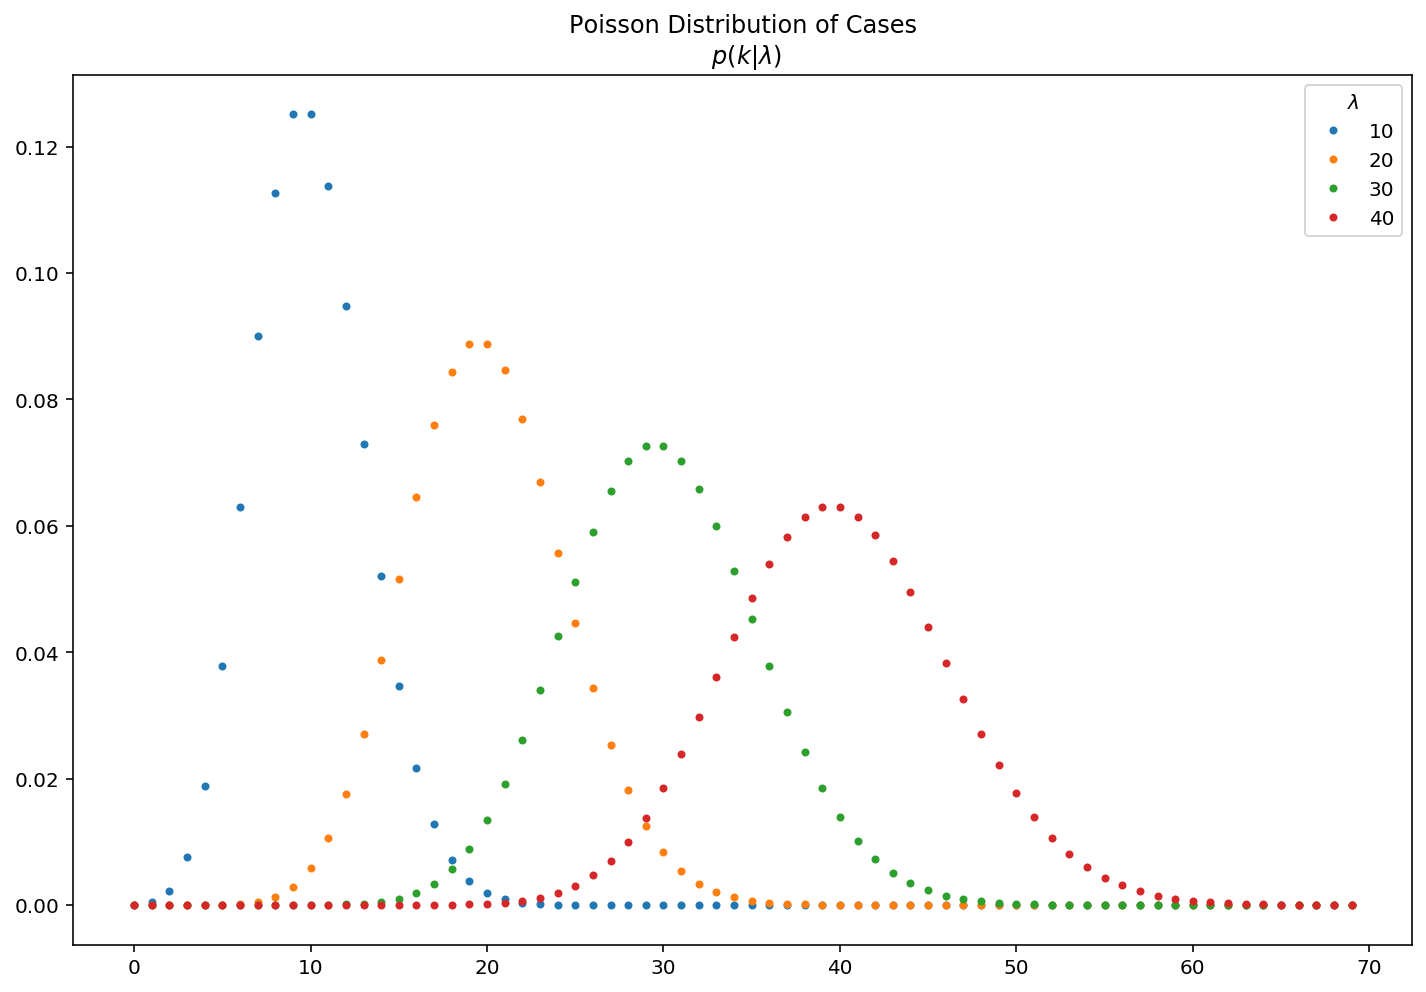

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

The Poisson distribution says that if you think you're going to have $\lambda$ cases per day, you'll probably get that many, plus or minus some variation based on chance.

But in our case, we know there have been $k$ cases and we need to know what value of $\lambda$ is most likely. In order to do this, we fix $k$ in place while varying $\lambda$. __This is called the likelihood function.__

For example, imagine we observe $k=20$ new cases, and we want to know how likely each $\lambda$ is:

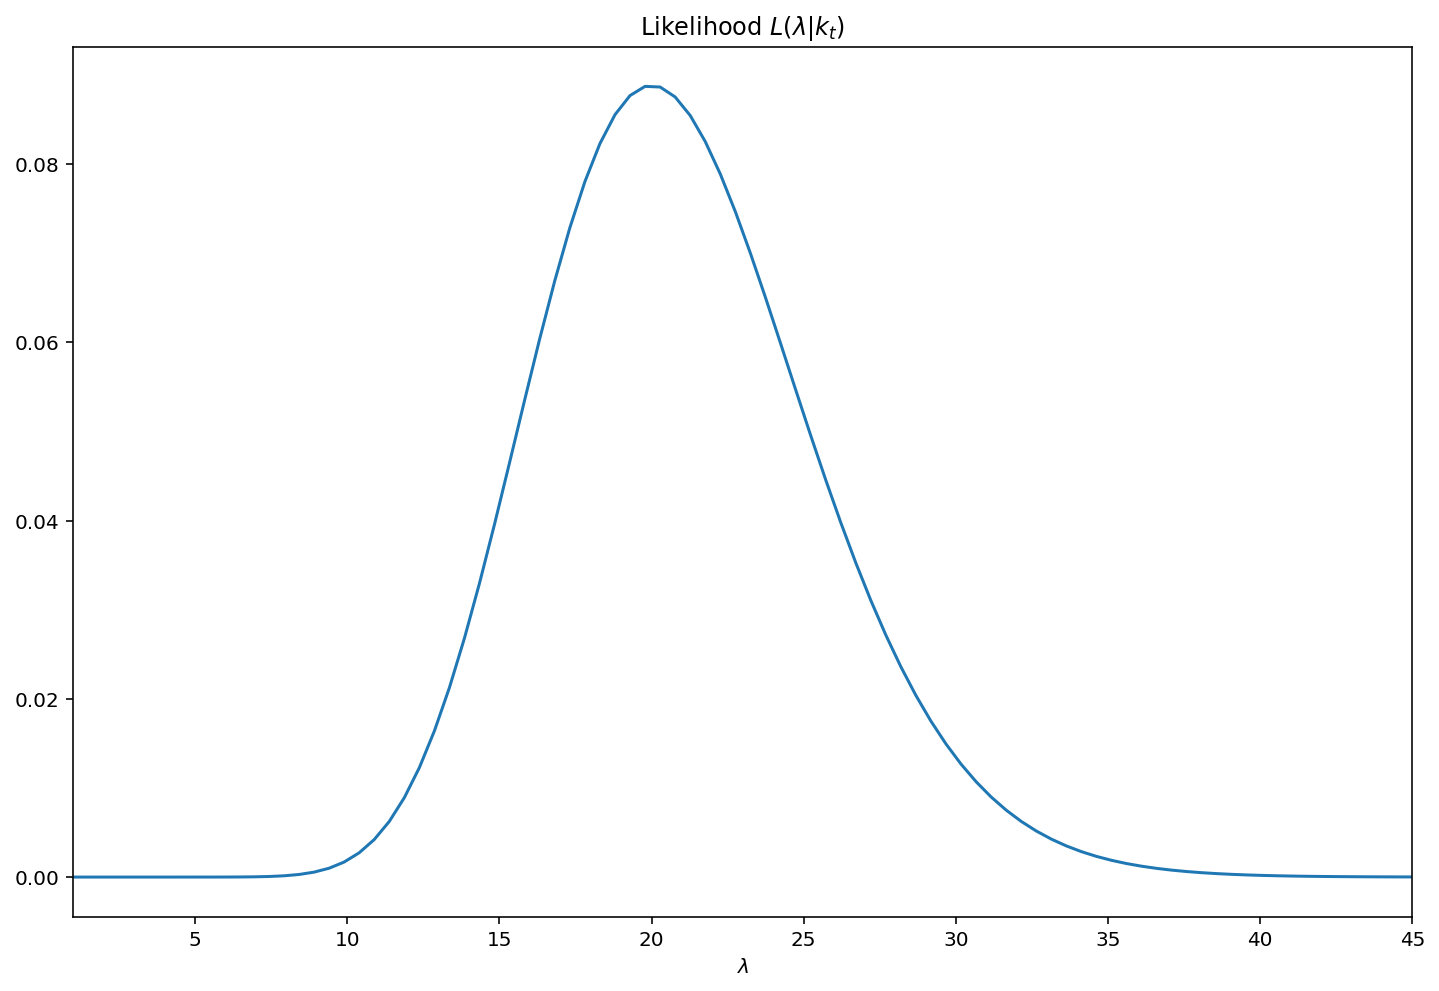

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $L\left(\lambda|k_t\right)$', figsize=(12, 8));

This says that if we see 20 cases, the most likely value of $\lambda$ is (not surprisingly) 20. But we're not certain: it's possible lambda was 21 or 17 and saw 20 new cases by chance alone. It also says that it's unlikely $\lambda$ was 40 and we saw 20.

Great. We have $\mathcal{L}\left(\lambda_t|k_t\right)$ which is parameterized by $\lambda$ but we were looking for $\mathcal{L}\left(R_t|k_t\right)$ which is parameterized by $R_t$. We need to know the relationship between $\lambda$ and $R_t$

### Connecting $\lambda$ and $R_t$

__The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$__. [The derivation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) is beyond the scope of this notebook, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

where $\gamma$ is the reciprocal of the serial interval ([about 4 days for COVID19](https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article)). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

$$\mathcal{L}\left(R_t|k\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Evaluating the Likelihood Function

To contiue our example, let's imagine a sample of new case counts $k$. What is the likelihood of different values of $R_t$ on each of those days?

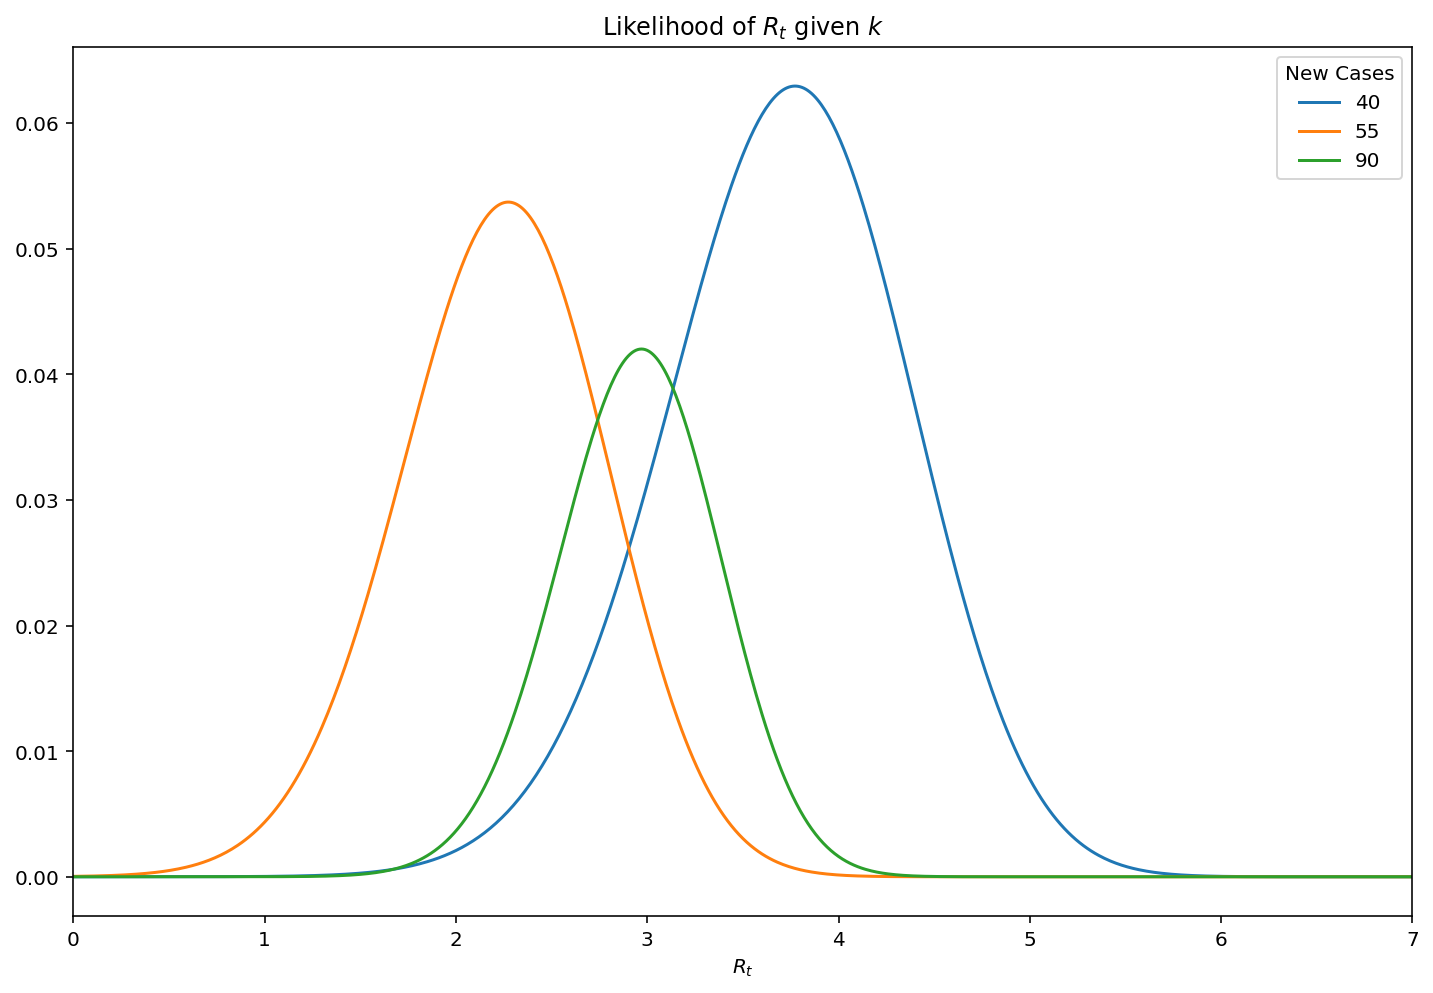

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t / np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,7), 
    figsize=(12, 8)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

You can see that each day we have a independent guesses for $R_t$. The goal is to combine the information we have about previous days with the current day. To do this, we use Bayes' theorem.

### Performing the Bayesian Update

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood) to get the posteriors. Let's do that using the cumulative product of each successive day:

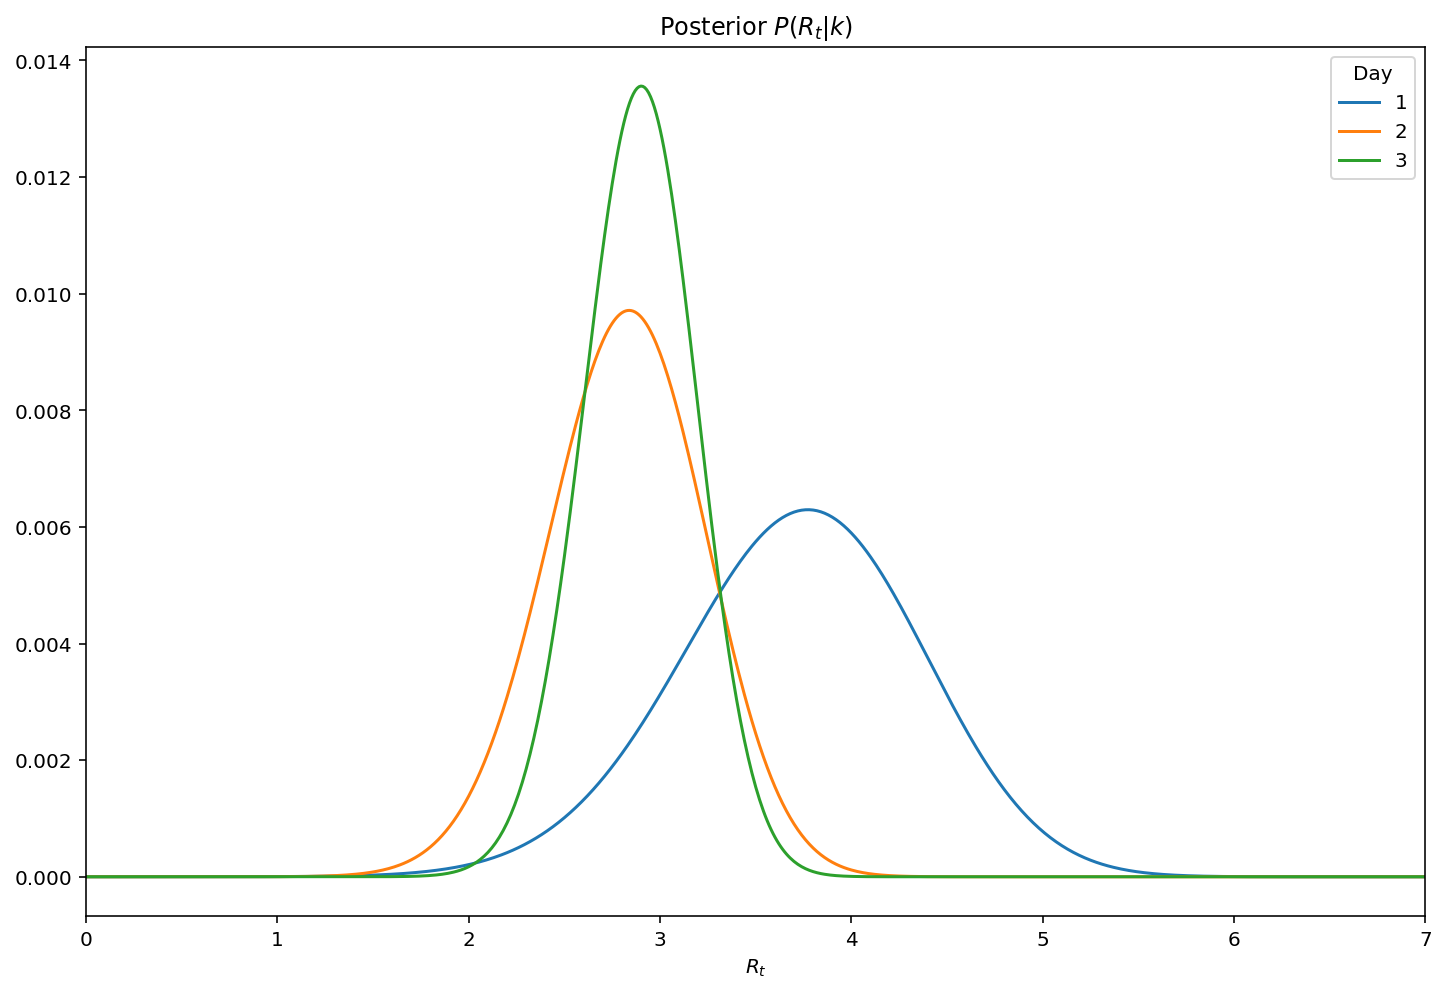

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,7),
    figsize=(12, 8)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Notice how on Day 1, our posterior matches Day 1's likelihood from above? That's because we have no information other than that day. However, when we update the prior using Day 2's information, you can see the curve has moved left, but not nearly as left as the likelihood for Day 2 from above. This is because Bayesian updating uses information from both days and effectively averages the two. Since Day 3's likelihood is in between the other two, you see a small shift to the right, but more importantly: a narrower distribution. We're becoming __more__ confident in our believes of the true value of $R_t$.

From these posteriors, we can answer important questions such as "What is the most likely value of $R_t$ each day?"

In [7]:
most_likely_values = posteriors.idxmax(axis=0)

We can also obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$:

> Note: I apologize in advance for the clunky brute force HDI algorithm. Please let me know if there are better ones out there.

In [8]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
       
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

Finally, we can plot both the most likely values for $R_t$ and the HDIs over time. This is the most useful representation as it shows how our beliefs change with every day.

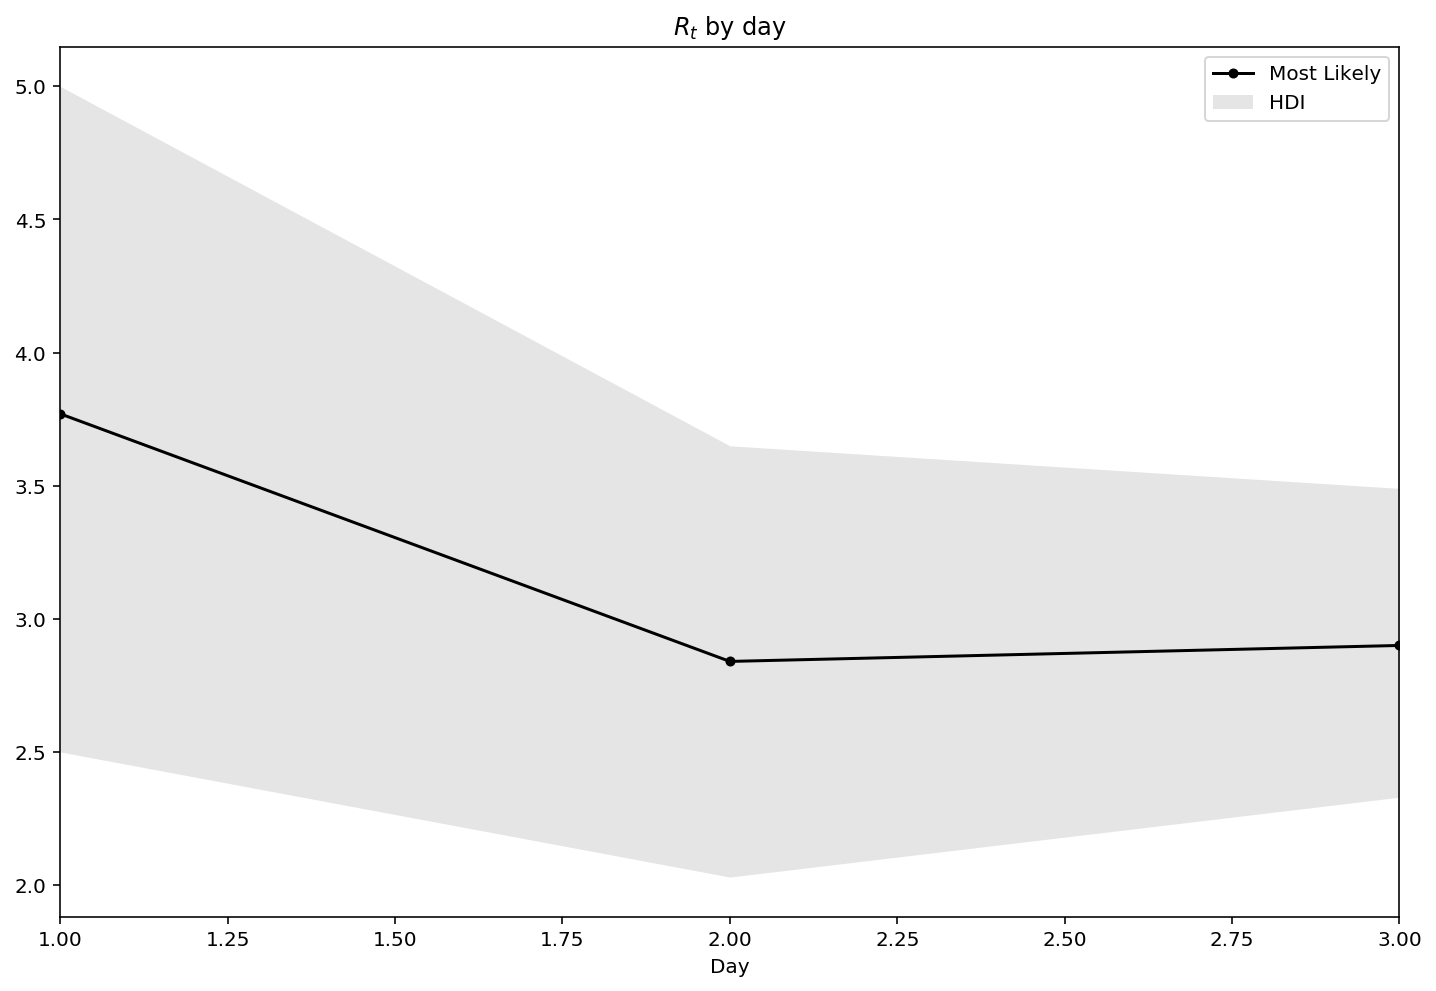

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4,
                             figsize=(12, 8))

ax.fill_between(hdi.index,
                hdi['Low'],
                hdi['High'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

We can see that the most likely value of $R_t$ changes with time and the highest-density interval narrows as we become more sure of the true value of $R_t$ over time. Note that since we only had four days of history, I did not apply my windowing modification to this sample. Next, however, we'll turn to a real-world application where this modification is necessary.

# Real-World Application to UK Data

### Setup

Load UK case data and aggregate by county

In [10]:
from covid.config import DATA_FOLDER

UK_REF = 'uk-covid-gov.csv'
df_uk_raw = pd.read_csv(DATA_FOLDER.joinpath(UK_REF), parse_dates=['Specimen date'])

In [11]:
df_uk_raw.head(3)

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
0,England,E92000001,Nation,2020-05-03,69.0,0.0,69.0,126346,124861.0,1485.0
1,South West,E12000009,Region,2020-05-03,15.0,NaN,NaN,6571,NaN,NaN
2,South East,E12000008,Region,2020-05-03,14.0,NaN,NaN,17756,NaN,NaN


In [12]:
df_uk_raw = pd.read_csv(DATA_FOLDER.joinpath(UK_REF), usecols=[0, 2, 3, 4, 7], parse_dates=['Specimen date'])
df_uk_raw.head(10)

,Area name,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases
0,England,Nation,2020-05-03,69.0,126346
1,South West,Region,2020-05-03,15.0,6571
2,South East,Region,2020-05-03,14.0,17756
3,London,Region,2020-05-03,1.0,24988
4,East of England,Region,2020-05-03,2.0,11077
5,West Midlands,Region,2020-05-03,5.0,13788
6,East Midlands,Region,2020-05-03,6.0,7143
7,Yorkshire and The Humber,Region,2020-05-03,16.0,10982
8,North West,Region,2020-05-03,1.0,20428
9,North East,Region,2020-05-03,8.0,8251


In [13]:
df_uk_raw.rename(columns={'Area name': 'Area', 
                          'Cumulative lab-confirmed cases': 'cases', 
                          'Specimen date': 'Date'}, 
                 inplace=True)

In [14]:
df_uk_raw.columns

Index(['Area', 'Area type', 'Date', 'Daily lab-confirmed cases', 'cases'], dtype='object')

In [15]:
df_uk = df_uk_raw[df_uk_raw['Area type'] == 'Region'][['Area', 'Date', 'cases']].sort_values(['Date', 'Area'])
df_uk = df_uk.set_index(['Area', 'Date']).squeeze()

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

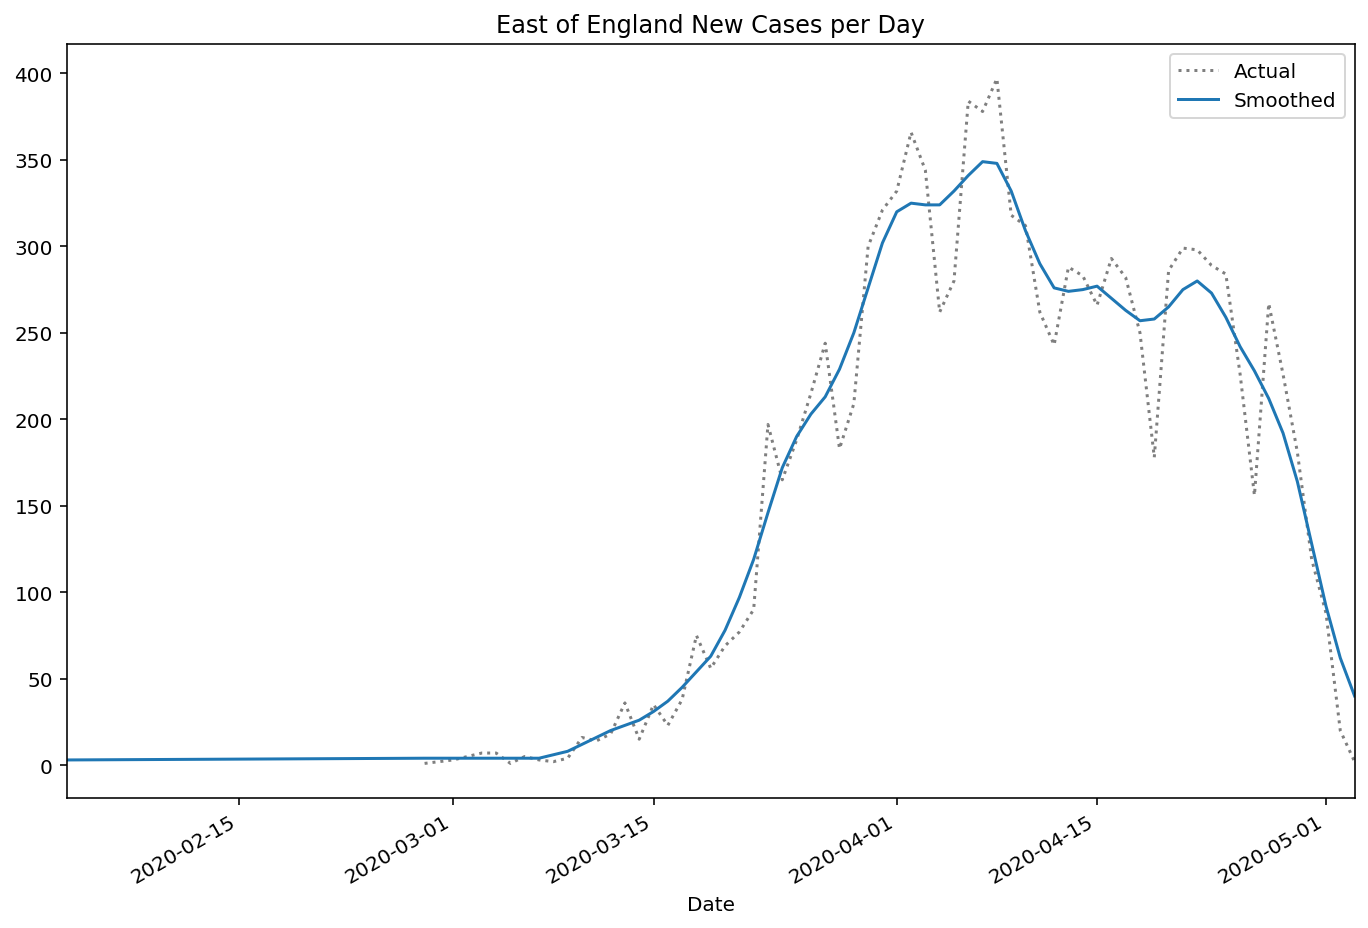

In [16]:
region = 'East of England'
fig_factor = 52. # prev. 72

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = df_uk.xs(region).rename(f"{region} cases")

original, smoothed = prepare_cases(cases)

if not original.empty:
    original.plot(
        title=f"{region} New Cases per Day",
        c='k',
        linestyle=':',
        alpha=.5,
        label='Actual',
        legend=True,
        figsize=(600/fig_factor, 400/fig_factor))

    ax = smoothed.plot(label='Smoothed',
                       legend=True)
    ax.get_figure().set_facecolor('w')

else:
    print("Not enough data")

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [17]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

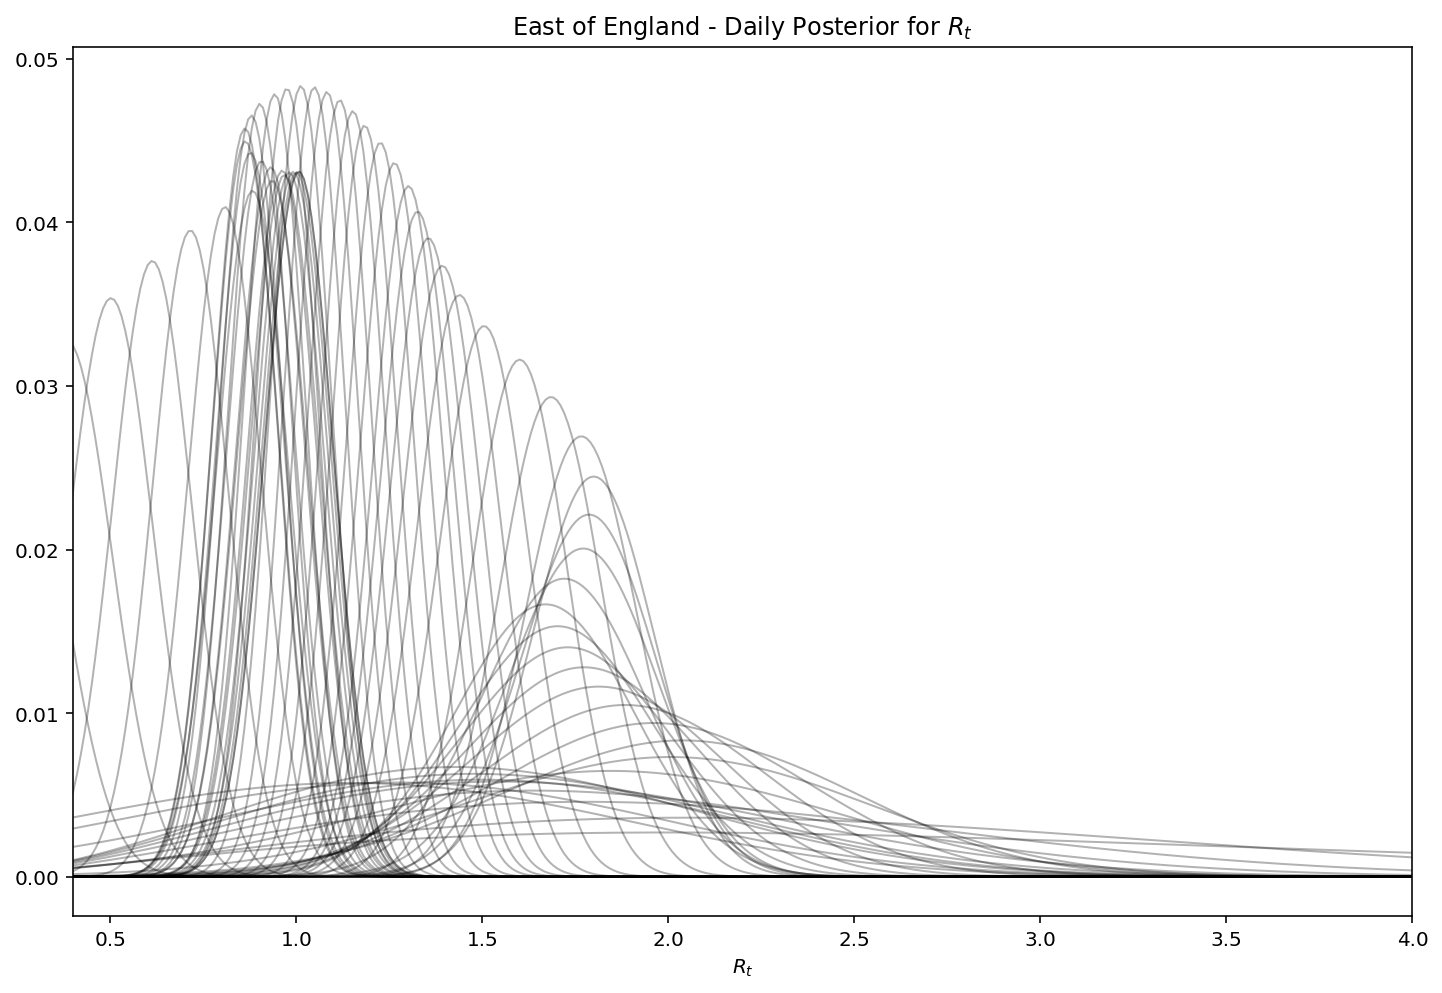

In [18]:
ax = posteriors.plot(title=f'{region} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4),
           figsize=(12, 8))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [19]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
Date,,,
2020-04-29,0.71,0.52,0.92
2020-04-30,0.61,0.41,0.83
2020-05-01,0.50,0.29,0.74
2020-05-02,0.38,0.15,0.63
2020-05-03,0.23,0.01,0.47


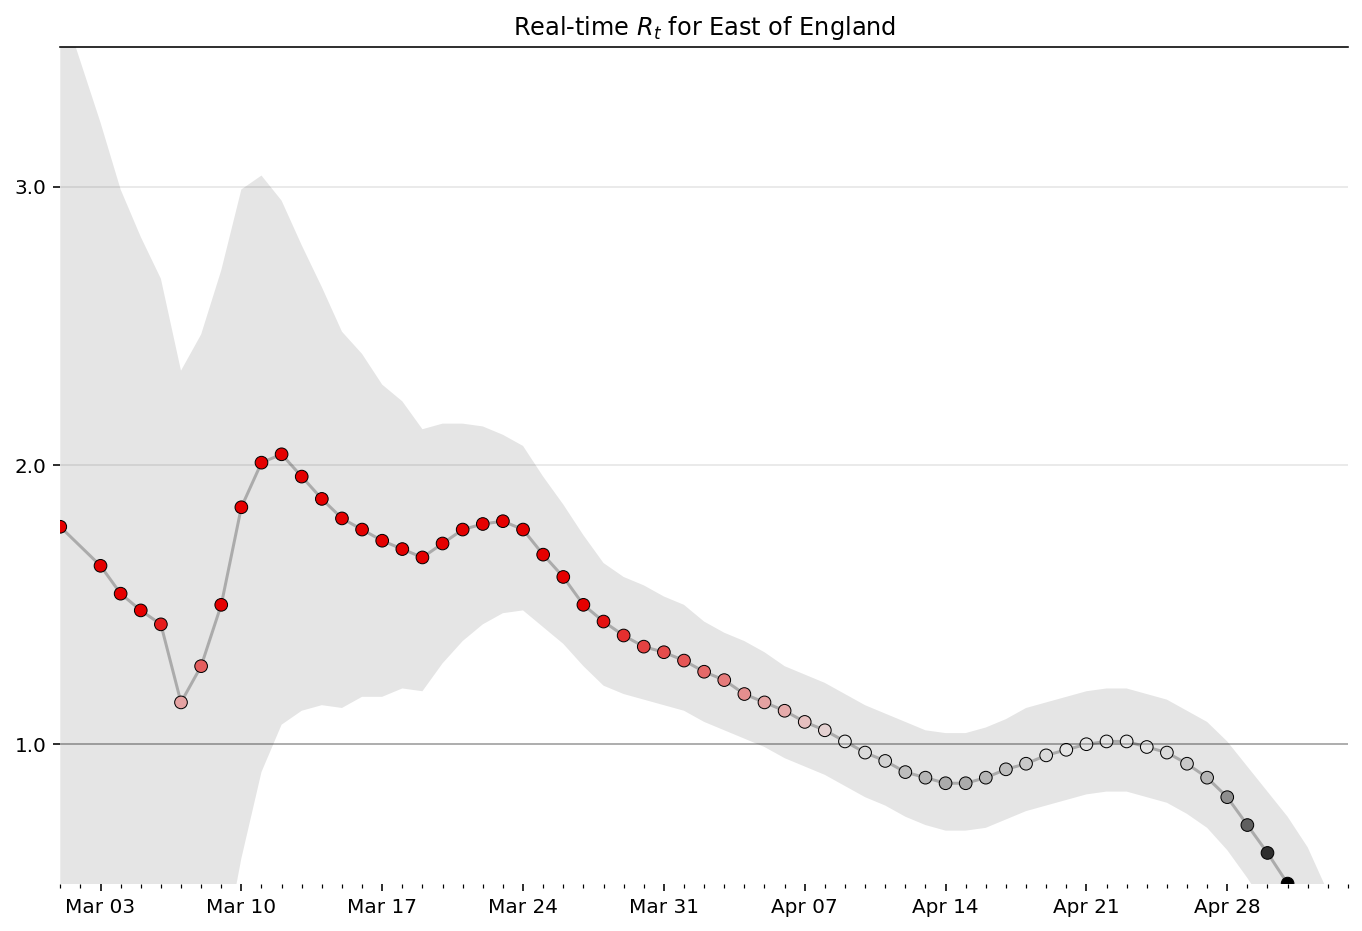

In [20]:
def plot_rt(result, ax, region):
    
    ax.set_title(f"{region}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_left()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('Date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/fig_factor, 400/fig_factor))

plot_rt(result, ax, region)
ax.set_title(f'Real-time $R_t$ for {region}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Repeat the Process for Every Region

In [21]:
results = {}
FILTER_REGION = []

for region_name, cases in df_uk.groupby(level='Area'):
    clear_output(wait=True)
    print(f'Processing: \t{region_name}')
    new, smoothed = prepare_cases(cases)
    if new.empty or smoothed.empty:
        FILTER_REGION.append(region_name)
        continue
        
    print('\t\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\t\tGetting HDIs')
    
    try:
        hdis = highest_density_interval(posteriors)
    except:
        FILTER_REGION.append(region_name)
        continue
    
    print('\t\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[region_name] = result.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


### Plot All UK data

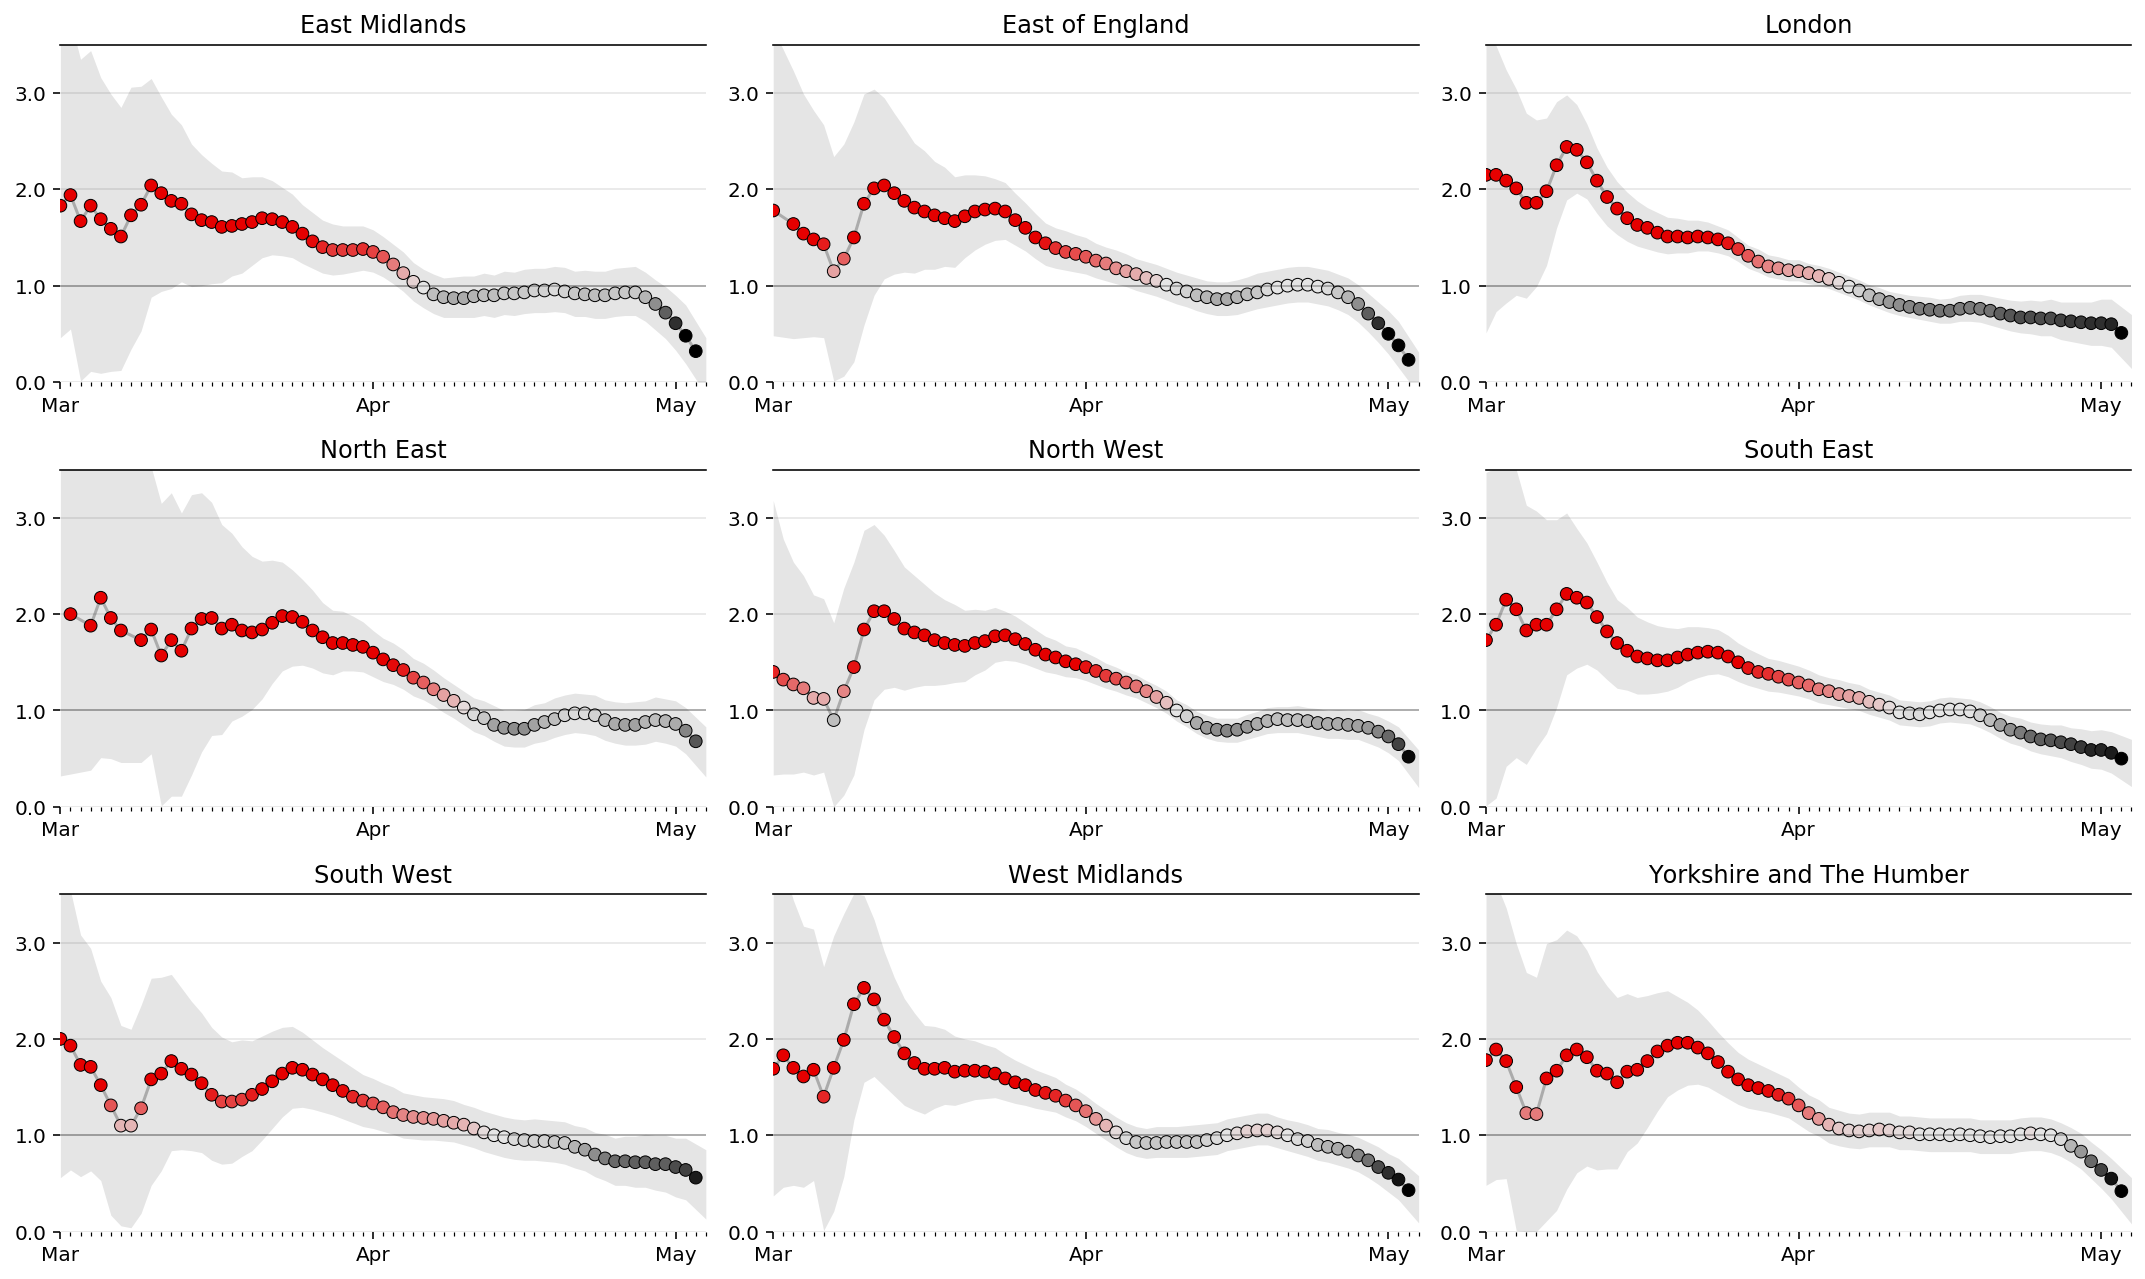

In [22]:
ncols = 3
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (region_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], region_name)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [23]:
overall = None

for region_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[region_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

# Uncomment this line if you'd like to export
# overall.to_csv(ROOT.joinpath('data/uk_rt.csv').to_posix())

### Standings

In [24]:
FULL_COLOR = [.7, .7, .7]
NONE_COLOR = [179/255, 35/255, 14/255]
PARTIAL_COLOR = [.5, .5, .5]
ERROR_BAR_COLOR = [.3, .3, .3]

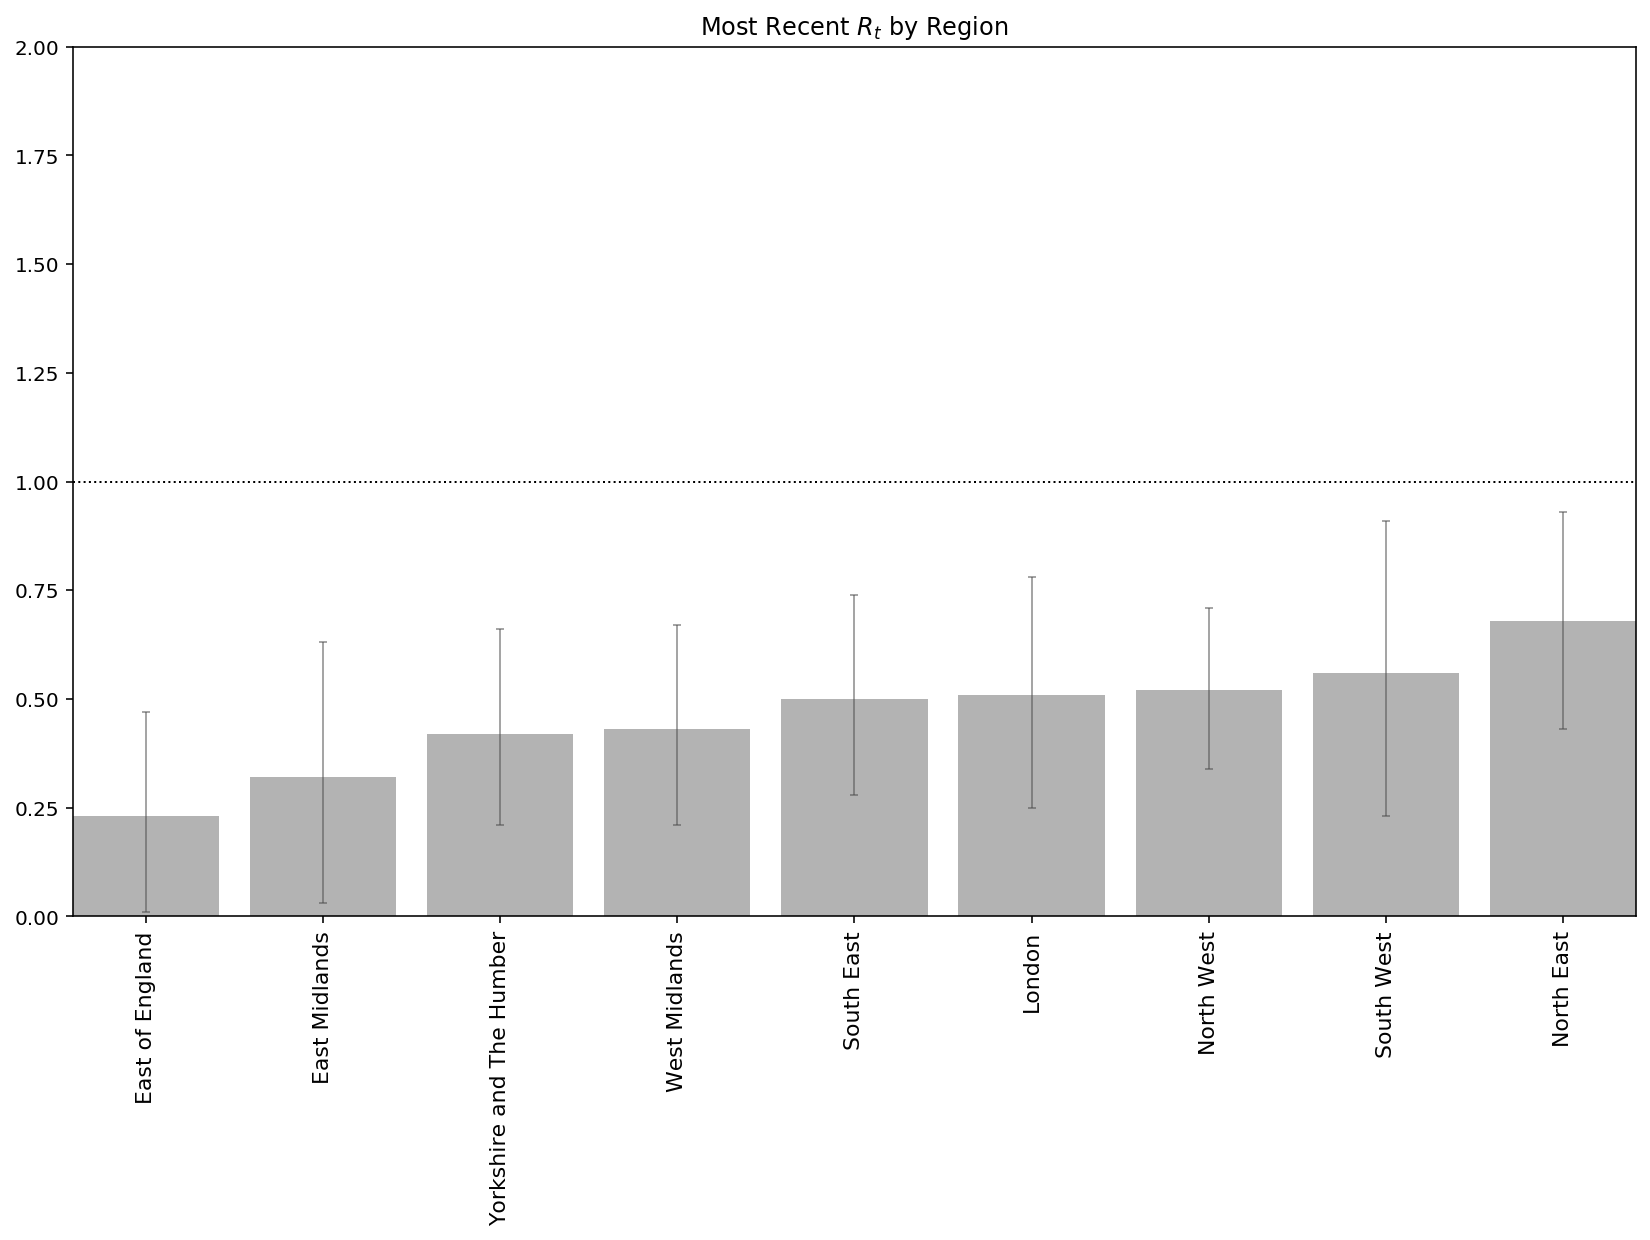

In [25]:
mr = overall.groupby(level=0)[['ML', 'High', 'Low']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Region', legend=False):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1, 2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if legend == True:
        leg = ax.legend(handles=[
                            Patch(label='Full', color=FULL_COLOR),
                            Patch(label='Partial', color=PARTIAL_COLOR),
                            Patch(label='None', color=NONE_COLOR)
                        ],
                        title='Lockdown',
                        ncol=3,
                        loc='upper left',
                        columnspacing=.75,
                        handletextpad=.5,
                        handlelength=1)

        leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(14, 8));

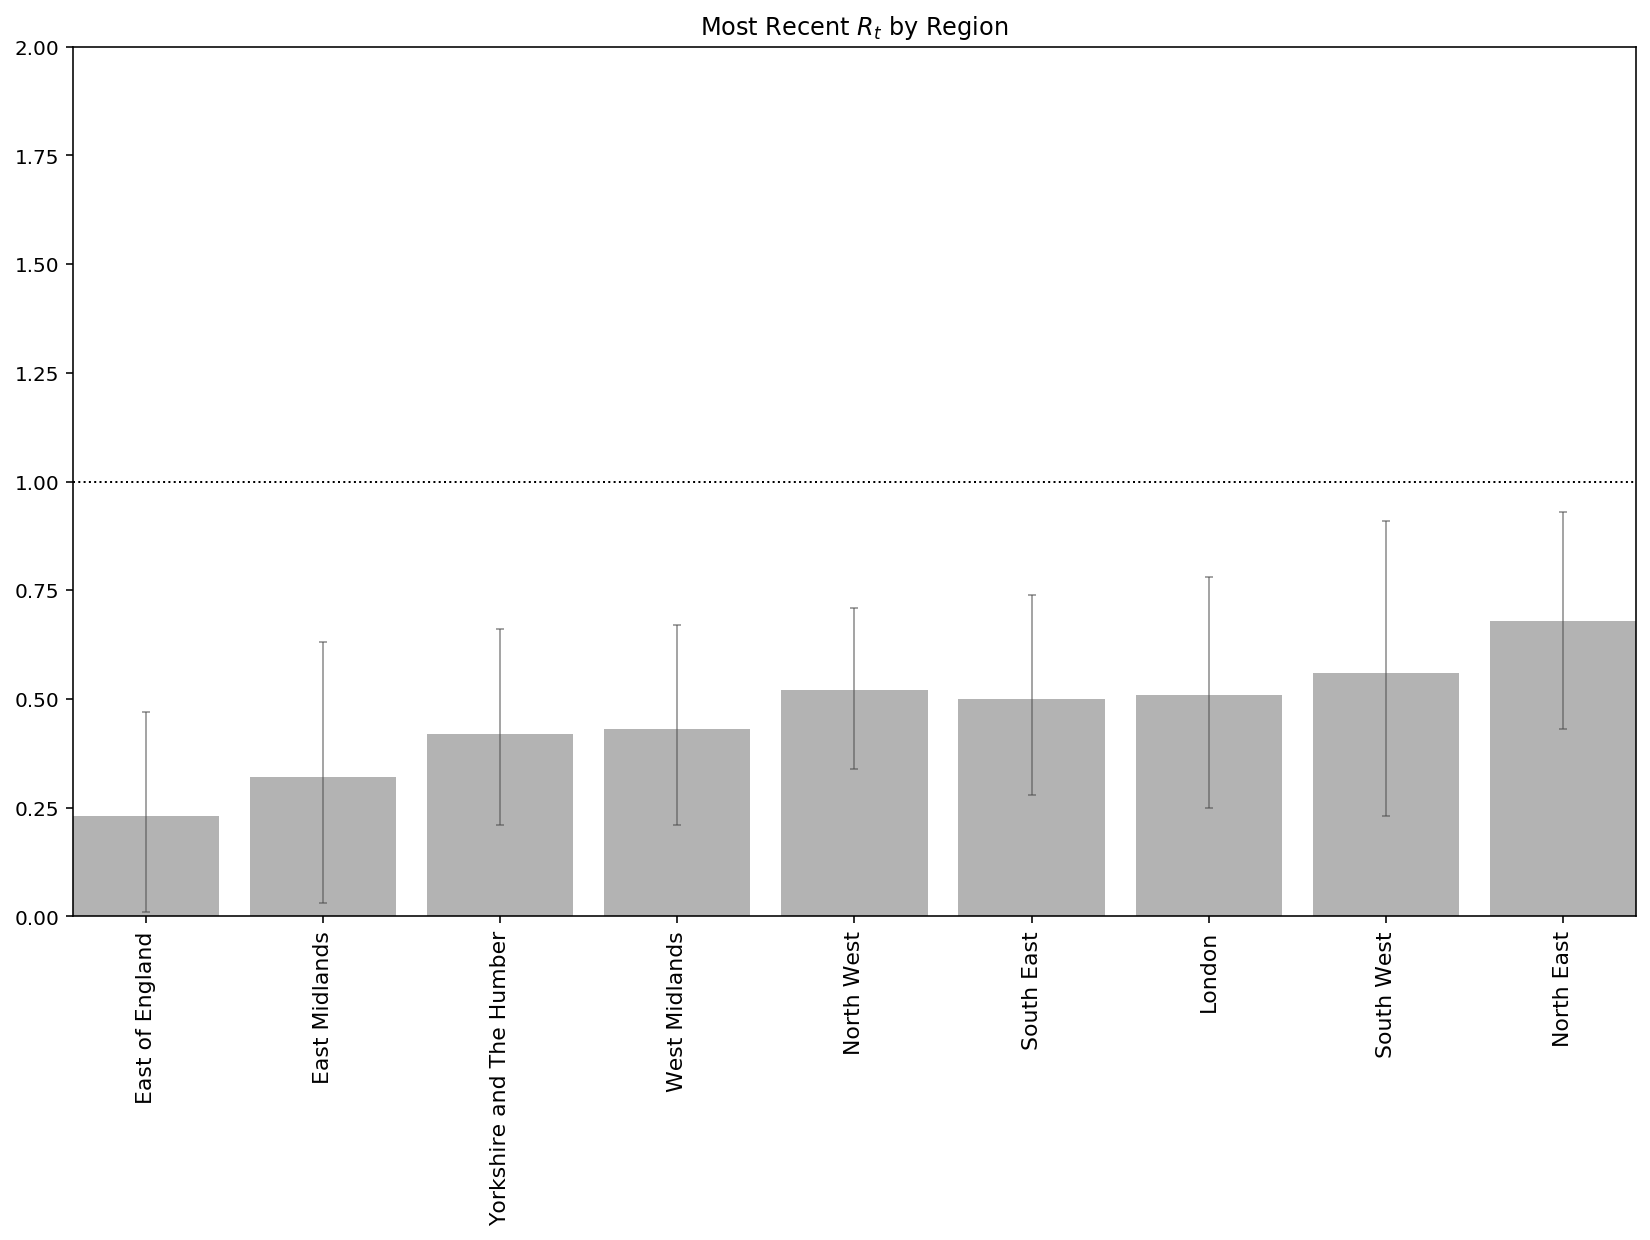

In [26]:
mr.sort_values('High', inplace=True)
plot_standings(mr, figsize=(14, 8));

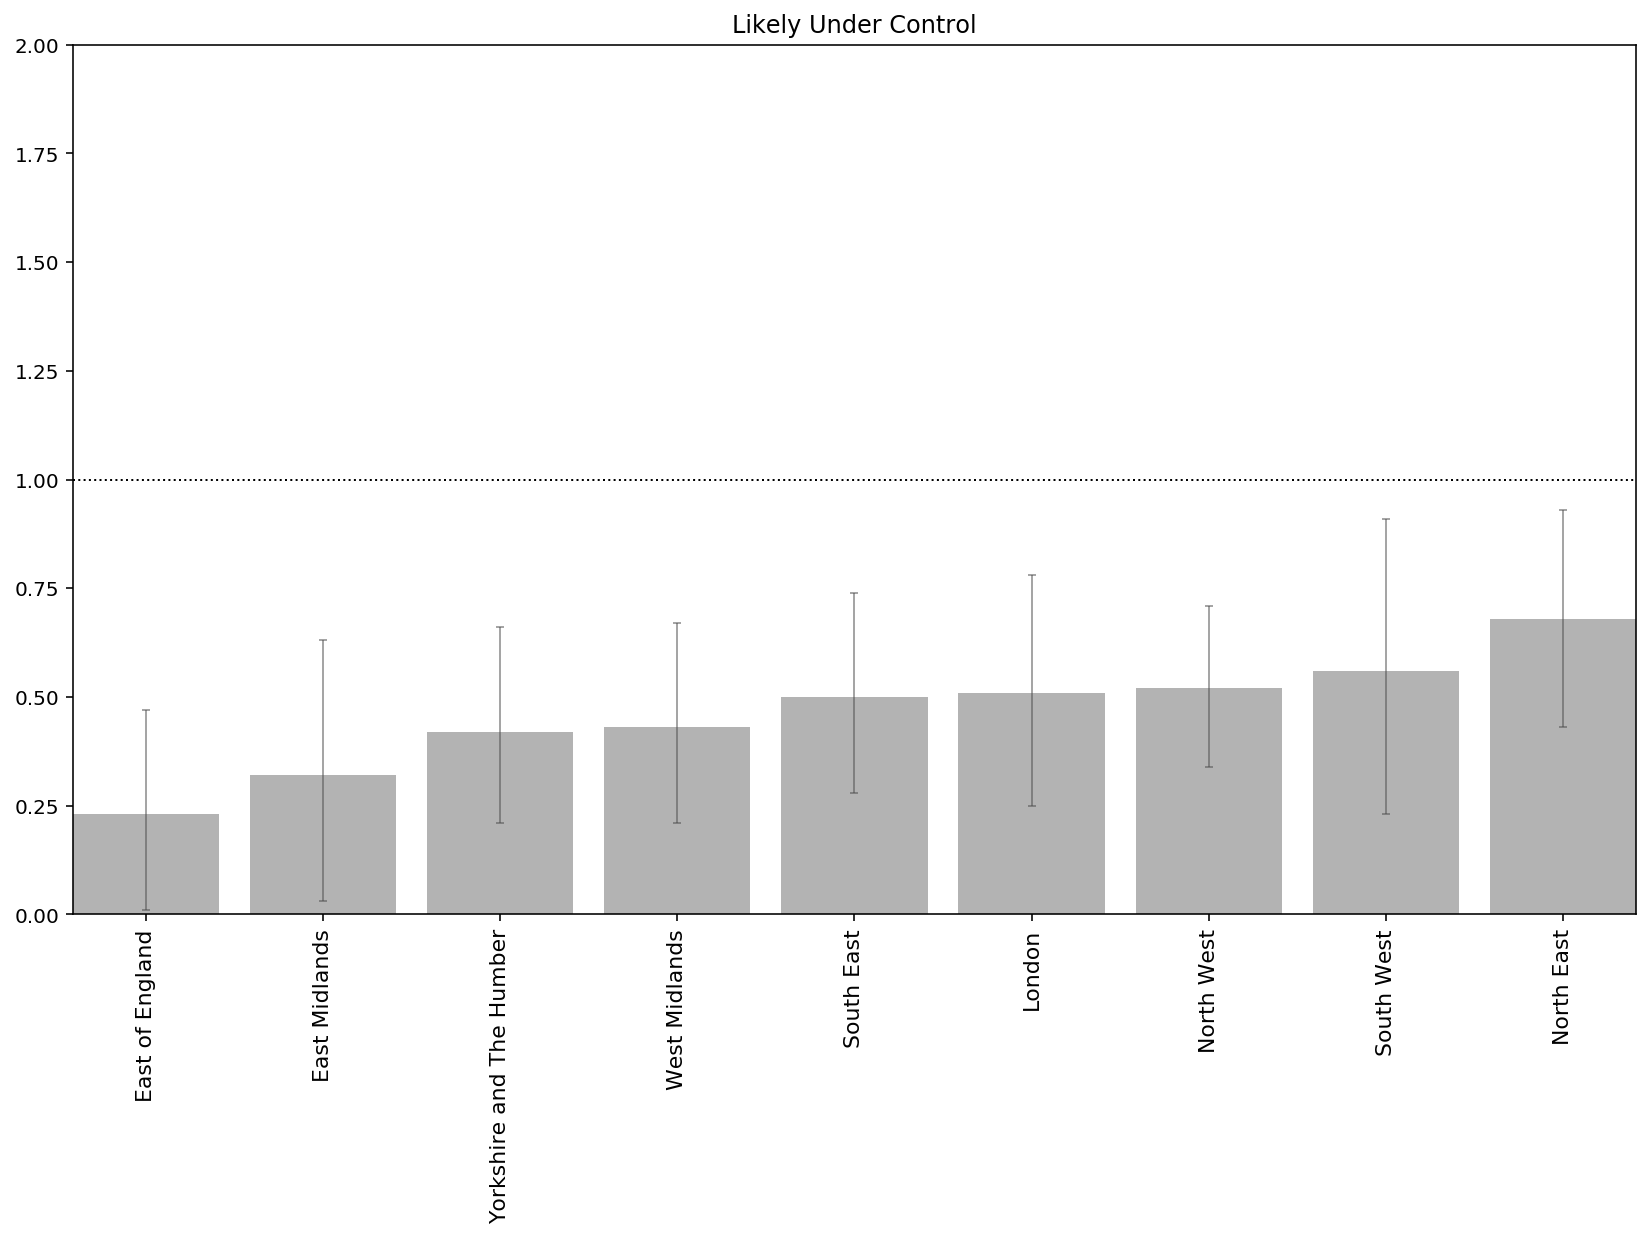

In [27]:
show = mr[mr.High.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control', figsize=(14, 8));

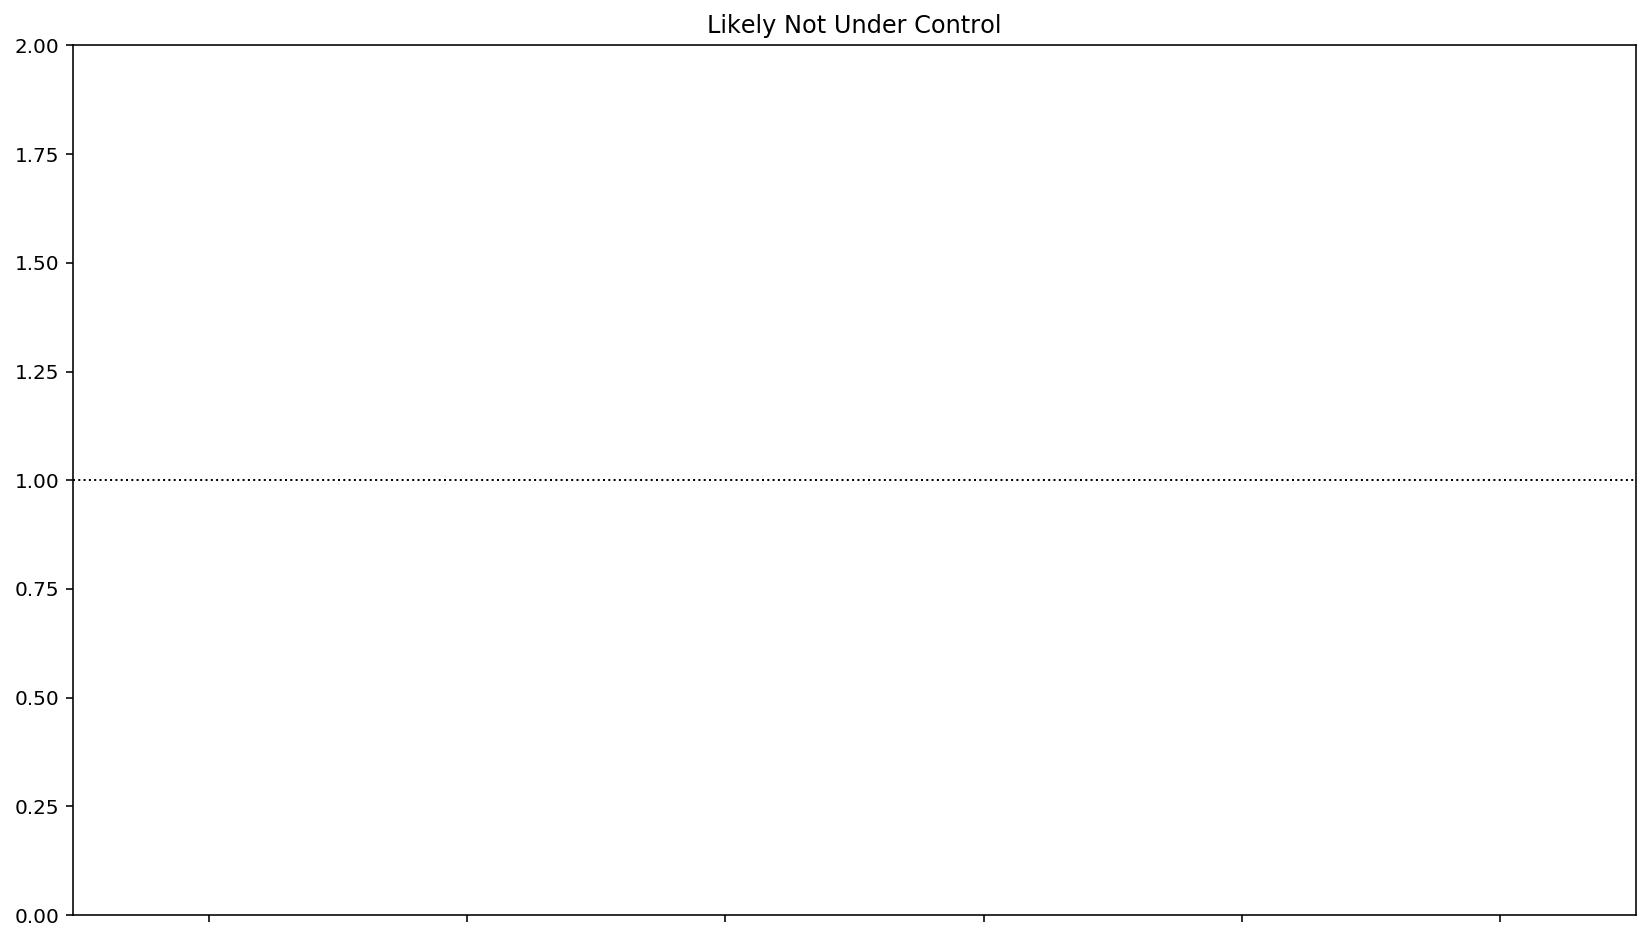

In [28]:
show = mr[mr.Low.ge(1.05)].sort_values('Low')
fig, ax = plot_standings(show, title='Likely Not Under Control', figsize=(14, 8));